<a href="https://colab.research.google.com/github/SiLiKhon/MLatNLCS2024/blob/main/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial attack example

In this example, we'll take this [image of a goldfish](https://www.pexels.com/photo/a-goldfish-in-a-plastic-bag-8434694/) and try to modify it slightly to trick the model into thinking it's something else:

![goldfish](https://raw.githubusercontent.com/SiLiKhon/MLatNLCS2024/main/pexels-mart-production-8434694.jpg)

**Note:**

If you're running this notebook interactively on Google Colab, it's a good idea to click `Edit -> Clear all outputs` before proceeding to avoid spoilers. :)

In [1]:
# Preparation - download the image:
!wget "https://raw.githubusercontent.com/SiLiKhon/MLatNLCS2024/main/pexels-mart-production-8434694.jpg" \
  -O "pexels-mart-production-8434694.jpg" \
  -o "download.log"

We are going to take a model that has been trained to classify images on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset. The particular model we are trying is called [EfficientNet](https://en.wikipedia.org/wiki/EfficientNet). For other available pre-trained models, check out [`torchvision.models` documentation](https://pytorch.org/vision/stable/models.html).

In [2]:
# importing the model code from torchvision library
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# this will define which particular state of the model we want to load
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1

# initialize the model and load the weights
model = efficientnet_v2_s(weights=weights)

# set the model into evaluation (rather than training) mode
model.eval()

# get the funcion that resizes and adjusts the input image as the model expects
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 102MB/s]


In [3]:
# import a helper function for loading images from disc
from torchvision.io import decode_image

# Load the image. Note: you can upload your own image via Google Colab
# interface (left sidebar, "Files" tab -> "Upload to session storage") and load
# it here instead by changing the filename argument of `decode_image` function.
img = decode_image("pexels-mart-production-8434694.jpg")

# resize and adjust the pixel brightness levels range as the model expects
prep_img = preprocess(img)

In [4]:
# Examine the sizes, data types and brightness ranges before and after
# preprocessing the image

print("Before preprocessing:")
print(f"{img.shape=}")
print(f"{img.dtype=}")
print(f"{img.min()=}")
print(f"{img.max()=}")

print("\nAfter preprocessing:")
print(f"{prep_img.shape=}")
print(f"{prep_img.dtype=}")
print(f"{prep_img.min()=}")
print(f"{prep_img.max()=}")

Before preprocessing:
img.shape=torch.Size([3, 427, 640])
img.dtype=torch.uint8
img.min()=tensor(0, dtype=torch.uint8)
img.max()=tensor(255, dtype=torch.uint8)

After preprocessing:
prep_img.shape=torch.Size([3, 384, 384])
prep_img.dtype=torch.float32
prep_img.min()=tensor(-1.9482)
prep_img.max()=tensor(2.6400)


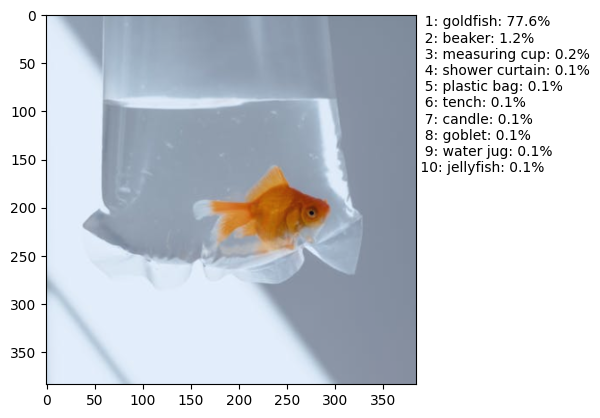

In [5]:
# Here we write helper functions to plot an image and calcuate the model's
# predictions for it


import matplotlib.pyplot as plt
import numpy as np

def plot_img(img, normalize=True):
    img = img.detach().numpy()
    if normalize:
        img = (img - img.min()) / (img.max() - img.min())
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

def predict_for_img(img, top_n=10):
    prediction = model(img.unsqueeze(0)).squeeze(0).softmax(0)  # <--- here we invoke the model to get predictions

    # get top n predicted classes
    top_ids = prediction.argsort(descending=True)[: top_n]
    prob_strings = []
    for i, class_id in enumerate(top_ids, 1):
        score = prediction[class_id].item()
        category_name = weights.meta["categories"][class_id]
        prob_strings.append(f"{i:3d}: {category_name}: {100 * score:.1f}%")

    # plot the image and add a text box with top predicted classes
    plot_img(img)
    plt.text(img.shape[1], 0, "\n".join(prob_strings), va="top")

predict_for_img(prep_img)

Ok, now we have everything in place to perform the attack!

 22%|██▏       | 11/50 [00:16<01:00,  1.54s/it]

Reached high probability. Stopping...


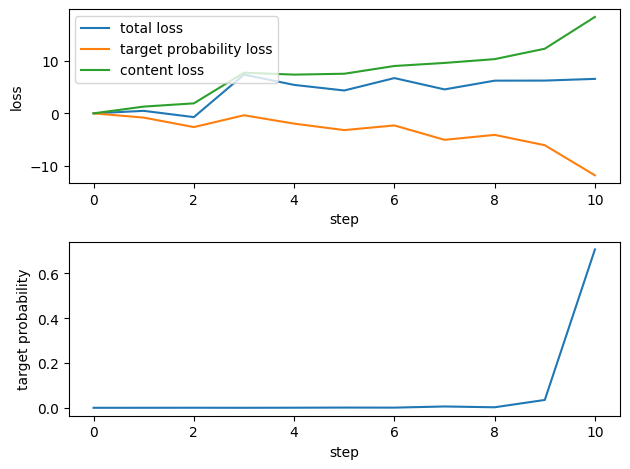

In [6]:
import torch
from tqdm import trange

target_category = "zucchini"   # <--- we'll modify the image to maximize the model's score for this category
target_id = weights.meta["categories"].index(target_category)

max_steps = 50
learning_rate = 1

original_img = preprocess(img).clone()
adversarial_img = original_img.clone().detach()
adversarial_img.requires_grad = True

history = {
    "total loss": [],
    "target probability": [],
    "target probability loss": [],
    "content loss": [],
}
for _ in trange(max_steps):
    scores = model(adversarial_img.unsqueeze(0)).squeeze(0)
    target_probability = scores.softmax(0)[target_id].item()
    if target_probability >= 0.8:
        print("Reached high probability. Stopping...")
        break

    target_loss = torch.concatenate(                        # These lines define the `loss` function to minimize.
        [scores[:target_id], scores[target_id + 1:]]        # We build it such that it is smallest when
    ).max() - scores[target_id]                             # the model favors the `target_category` over
    content_loss = (adversarial_img - original_img).norm()  # the others (via `target_loss`), while also
    loss = target_loss + content_loss                       # preserving the modified image close to the
                                                            # original (via `content_loss`).
    loss.backward()  # calculate gradient of the loss
    with torch.no_grad():
        adversarial_img.data -= learning_rate * adversarial_img.grad.data  # update the image
    adversarial_img.grad.zero_()
    model.zero_grad()

    history["target probability"].append(target_probability)
    history["target probability loss"].append(target_loss.item())
    history["content loss"].append(content_loss.item())
    history["total loss"].append(loss.item())


# Plot the evolution of loss values and target probability.
plt.subplot(2, 1, 1)
for k, v in history.items():
    if k == "target probability": continue
    plt.plot(np.array(v) - v[0], label=k)
plt.xlabel("step")
plt.ylabel("loss")
plt.legend();
plt.subplot(2, 1, 2)
plt.plot(history["target probability"])
plt.xlabel("step")
plt.ylabel("target probability")
plt.tight_layout();

Now let's compare predictions before and after the attack:

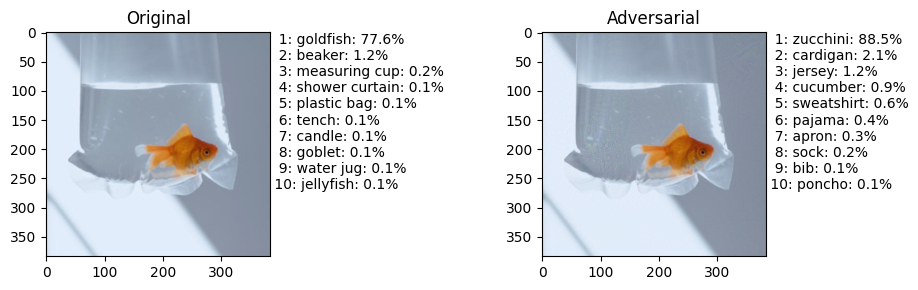

In [7]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
predict_for_img(original_img)

plt.subplot(1, 2, 2)
plt.title("Adversarial")
predict_for_img(adversarial_img)

plt.tight_layout();

It might be difficult to see the difference between the two images, yet the model makes very different predictions on them.

The cell below plots the maps of brightness differences between the two images, per channel (in \%).

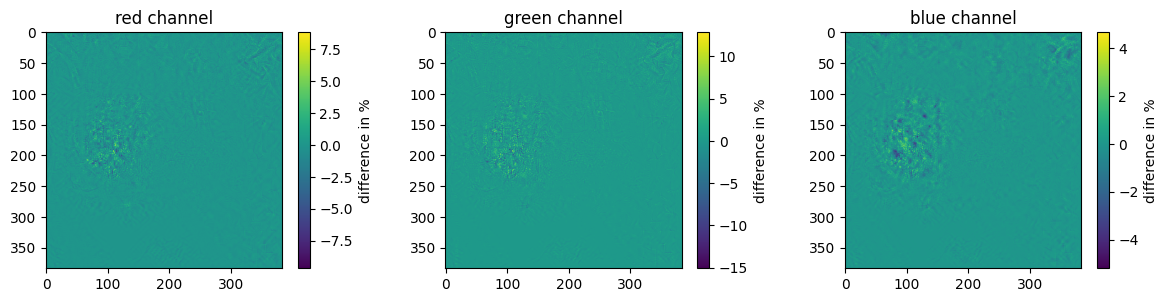

In [8]:
plt.figure(figsize=(12, 3))
for channel, title in enumerate(["red", "green", "blue"]):
    plt.subplot(1, 3, channel + 1)
    plt.title(f"{title} channel")
    dynamic_range = original_img[channel].max() - original_img[channel].min()
    diff = (
        (adversarial_img.detach()[channel] - original_img[channel])
        / dynamic_range * 100
    ).numpy()
    plt.imshow(diff)
    plt.colorbar(label="difference in %")
plt.tight_layout();

If you'd like to re-run this code for some other categories, the cell below produces the table of all the available categories to choose from.

In [9]:
from IPython.display import Markdown
import pandas as pd

categories_per_line = 20

Markdown(
    pd.DataFrame(
        data=[
            weights.meta["categories"][i: i + 20]
            for i in range(0, len(weights.meta["categories"]), categories_per_line)
        ],
        columns=range(categories_per_line)
    ).to_markdown(index=False)
)

| 0                              | 1                   | 2                           | 3                           | 4                     | 5                        | 6                      | 7                   | 8                       | 9                        | 10                          | 11                | 12                           | 13                   | 14                 | 15                  | 16                  | 17                   | 18                         | 19                        |
|:-------------------------------|:--------------------|:----------------------------|:----------------------------|:----------------------|:-------------------------|:-----------------------|:--------------------|:------------------------|:-------------------------|:----------------------------|:------------------|:-----------------------------|:---------------------|:-------------------|:--------------------|:--------------------|:---------------------|:---------------------------|:--------------------------|
| tench                          | goldfish            | great white shark           | tiger shark                 | hammerhead            | electric ray             | stingray               | cock                | hen                     | ostrich                  | brambling                   | goldfinch         | house finch                  | junco                | indigo bunting     | robin               | bulbul              | jay                  | magpie                     | chickadee                 |
| water ouzel                    | kite                | bald eagle                  | vulture                     | great grey owl        | European fire salamander | common newt            | eft                 | spotted salamander      | axolotl                  | bullfrog                    | tree frog         | tailed frog                  | loggerhead           | leatherback turtle | mud turtle          | terrapin            | box turtle           | banded gecko               | common iguana             |
| American chameleon             | whiptail            | agama                       | frilled lizard              | alligator lizard      | Gila monster             | green lizard           | African chameleon   | Komodo dragon           | African crocodile        | American alligator          | triceratops       | thunder snake                | ringneck snake       | hognose snake      | green snake         | king snake          | garter snake         | water snake                | vine snake                |
| night snake                    | boa constrictor     | rock python                 | Indian cobra                | green mamba           | sea snake                | horned viper           | diamondback         | sidewinder              | trilobite                | harvestman                  | scorpion          | black and gold garden spider | barn spider          | garden spider      | black widow         | tarantula           | wolf spider          | tick                       | centipede                 |
| black grouse                   | ptarmigan           | ruffed grouse               | prairie chicken             | peacock               | quail                    | partridge              | African grey        | macaw                   | sulphur-crested cockatoo | lorikeet                    | coucal            | bee eater                    | hornbill             | hummingbird        | jacamar             | toucan              | drake                | red-breasted merganser     | goose                     |
| black swan                     | tusker              | echidna                     | platypus                    | wallaby               | koala                    | wombat                 | jellyfish           | sea anemone             | brain coral              | flatworm                    | nematode          | conch                        | snail                | slug               | sea slug            | chiton              | chambered nautilus   | Dungeness crab             | rock crab                 |
| fiddler crab                   | king crab           | American lobster            | spiny lobster               | crayfish              | hermit crab              | isopod                 | white stork         | black stork             | spoonbill                | flamingo                    | little blue heron | American egret               | bittern              | crane bird         | limpkin             | European gallinule  | American coot        | bustard                    | ruddy turnstone           |
| red-backed sandpiper           | redshank            | dowitcher                   | oystercatcher               | pelican               | king penguin             | albatross              | grey whale          | killer whale            | dugong                   | sea lion                    | Chihuahua         | Japanese spaniel             | Maltese dog          | Pekinese           | Shih-Tzu            | Blenheim spaniel    | papillon             | toy terrier                | Rhodesian ridgeback       |
| Afghan hound                   | basset              | beagle                      | bloodhound                  | bluetick              | black-and-tan coonhound  | Walker hound           | English foxhound    | redbone                 | borzoi                   | Irish wolfhound             | Italian greyhound | whippet                      | Ibizan hound         | Norwegian elkhound | otterhound          | Saluki              | Scottish deerhound   | Weimaraner                 | Staffordshire bullterrier |
| American Staffordshire terrier | Bedlington terrier  | Border terrier              | Kerry blue terrier          | Irish terrier         | Norfolk terrier          | Norwich terrier        | Yorkshire terrier   | wire-haired fox terrier | Lakeland terrier         | Sealyham terrier            | Airedale          | cairn                        | Australian terrier   | Dandie Dinmont     | Boston bull         | miniature schnauzer | giant schnauzer      | standard schnauzer         | Scotch terrier            |
| Tibetan terrier                | silky terrier       | soft-coated wheaten terrier | West Highland white terrier | Lhasa                 | flat-coated retriever    | curly-coated retriever | golden retriever    | Labrador retriever      | Chesapeake Bay retriever | German short-haired pointer | vizsla            | English setter               | Irish setter         | Gordon setter      | Brittany spaniel    | clumber             | English springer     | Welsh springer spaniel     | cocker spaniel            |
| Sussex spaniel                 | Irish water spaniel | kuvasz                      | schipperke                  | groenendael           | malinois                 | briard                 | kelpie              | komondor                | Old English sheepdog     | Shetland sheepdog           | collie            | Border collie                | Bouvier des Flandres | Rottweiler         | German shepherd     | Doberman            | miniature pinscher   | Greater Swiss Mountain dog | Bernese mountain dog      |
| Appenzeller                    | EntleBucher         | boxer                       | bull mastiff                | Tibetan mastiff       | French bulldog           | Great Dane             | Saint Bernard       | Eskimo dog              | malamute                 | Siberian husky              | dalmatian         | affenpinscher                | basenji              | pug                | Leonberg            | Newfoundland        | Great Pyrenees       | Samoyed                    | Pomeranian                |
| chow                           | keeshond            | Brabancon griffon           | Pembroke                    | Cardigan              | toy poodle               | miniature poodle       | standard poodle     | Mexican hairless        | timber wolf              | white wolf                  | red wolf          | coyote                       | dingo                | dhole              | African hunting dog | hyena               | red fox              | kit fox                    | Arctic fox                |
| grey fox                       | tabby               | tiger cat                   | Persian cat                 | Siamese cat           | Egyptian cat             | cougar                 | lynx                | leopard                 | snow leopard             | jaguar                      | lion              | tiger                        | cheetah              | brown bear         | American black bear | ice bear            | sloth bear           | mongoose                   | meerkat                   |
| tiger beetle                   | ladybug             | ground beetle               | long-horned beetle          | leaf beetle           | dung beetle              | rhinoceros beetle      | weevil              | fly                     | bee                      | ant                         | grasshopper       | cricket                      | walking stick        | cockroach          | mantis              | cicada              | leafhopper           | lacewing                   | dragonfly                 |
| damselfly                      | admiral             | ringlet                     | monarch                     | cabbage butterfly     | sulphur butterfly        | lycaenid               | starfish            | sea urchin              | sea cucumber             | wood rabbit                 | hare              | Angora                       | hamster              | porcupine          | fox squirrel        | marmot              | beaver               | guinea pig                 | sorrel                    |
| zebra                          | hog                 | wild boar                   | warthog                     | hippopotamus          | ox                       | water buffalo          | bison               | ram                     | bighorn                  | ibex                        | hartebeest        | impala                       | gazelle              | Arabian camel      | llama               | weasel              | mink                 | polecat                    | black-footed ferret       |
| otter                          | skunk               | badger                      | armadillo                   | three-toed sloth      | orangutan                | gorilla                | chimpanzee          | gibbon                  | siamang                  | guenon                      | patas             | baboon                       | macaque              | langur             | colobus             | proboscis monkey    | marmoset             | capuchin                   | howler monkey             |
| titi                           | spider monkey       | squirrel monkey             | Madagascar cat              | indri                 | Indian elephant          | African elephant       | lesser panda        | giant panda             | barracouta               | eel                         | coho              | rock beauty                  | anemone fish         | sturgeon           | gar                 | lionfish            | puffer               | abacus                     | abaya                     |
| academic gown                  | accordion           | acoustic guitar             | aircraft carrier            | airliner              | airship                  | altar                  | ambulance           | amphibian               | analog clock             | apiary                      | apron             | ashcan                       | assault rifle        | backpack           | bakery              | balance beam        | balloon              | ballpoint                  | Band Aid                  |
| banjo                          | bannister           | barbell                     | barber chair                | barbershop            | barn                     | barometer              | barrel              | barrow                  | baseball                 | basketball                  | bassinet          | bassoon                      | bathing cap          | bath towel         | bathtub             | beach wagon         | beacon               | beaker                     | bearskin                  |
| beer bottle                    | beer glass          | bell cote                   | bib                         | bicycle-built-for-two | bikini                   | binder                 | binoculars          | birdhouse               | boathouse                | bobsled                     | bolo tie          | bonnet                       | bookcase             | bookshop           | bottlecap           | bow                 | bow tie              | brass                      | brassiere                 |
| breakwater                     | breastplate         | broom                       | bucket                      | buckle                | bulletproof vest         | bullet train           | butcher shop        | cab                     | caldron                  | candle                      | cannon            | canoe                        | can opener           | cardigan           | car mirror          | carousel            | carpenter's kit      | carton                     | car wheel                 |
| cash machine                   | cassette            | cassette player             | castle                      | catamaran             | CD player                | cello                  | cellular telephone  | chain                   | chainlink fence          | chain mail                  | chain saw         | chest                        | chiffonier           | chime              | china cabinet       | Christmas stocking  | church               | cinema                     | cleaver                   |
| cliff dwelling                 | cloak               | clog                        | cocktail shaker             | coffee mug            | coffeepot                | coil                   | combination lock    | computer keyboard       | confectionery            | container ship              | convertible       | corkscrew                    | cornet               | cowboy boot        | cowboy hat          | cradle              | crane                | crash helmet               | crate                     |
| crib                           | Crock Pot           | croquet ball                | crutch                      | cuirass               | dam                      | desk                   | desktop computer    | dial telephone          | diaper                   | digital clock               | digital watch     | dining table                 | dishrag              | dishwasher         | disk brake          | dock                | dogsled              | dome                       | doormat                   |
| drilling platform              | drum                | drumstick                   | dumbbell                    | Dutch oven            | electric fan             | electric guitar        | electric locomotive | entertainment center    | envelope                 | espresso maker              | face powder       | feather boa                  | file                 | fireboat           | fire engine         | fire screen         | flagpole             | flute                      | folding chair             |
| football helmet                | forklift            | fountain                    | fountain pen                | four-poster           | freight car              | French horn            | frying pan          | fur coat                | garbage truck            | gasmask                     | gas pump          | goblet                       | go-kart              | golf ball          | golfcart            | gondola             | gong                 | gown                       | grand piano               |
| greenhouse                     | grille              | grocery store               | guillotine                  | hair slide            | hair spray               | half track             | hammer              | hamper                  | hand blower              | hand-held computer          | handkerchief      | hard disc                    | harmonica            | harp               | harvester           | hatchet             | holster              | home theater               | honeycomb                 |
| hook                           | hoopskirt           | horizontal bar              | horse cart                  | hourglass             | iPod                     | iron                   | jack-o'-lantern     | jean                    | jeep                     | jersey                      | jigsaw puzzle     | jinrikisha                   | joystick             | kimono             | knee pad            | knot                | lab coat             | ladle                      | lampshade                 |
| laptop                         | lawn mower          | lens cap                    | letter opener               | library               | lifeboat                 | lighter                | limousine           | liner                   | lipstick                 | Loafer                      | lotion            | loudspeaker                  | loupe                | lumbermill         | magnetic compass    | mailbag             | mailbox              | maillot                    | maillot tank suit         |
| manhole cover                  | maraca              | marimba                     | mask                        | matchstick            | maypole                  | maze                   | measuring cup       | medicine chest          | megalith                 | microphone                  | microwave         | military uniform             | milk can             | minibus            | miniskirt           | minivan             | missile              | mitten                     | mixing bowl               |
| mobile home                    | Model T             | modem                       | monastery                   | monitor               | moped                    | mortar                 | mortarboard         | mosque                  | mosquito net             | motor scooter               | mountain bike     | mountain tent                | mouse                | mousetrap          | moving van          | muzzle              | nail                 | neck brace                 | necklace                  |
| nipple                         | notebook            | obelisk                     | oboe                        | ocarina               | odometer                 | oil filter             | organ               | oscilloscope            | overskirt                | oxcart                      | oxygen mask       | packet                       | paddle               | paddlewheel        | padlock             | paintbrush          | pajama               | palace                     | panpipe                   |
| paper towel                    | parachute           | parallel bars               | park bench                  | parking meter         | passenger car            | patio                  | pay-phone           | pedestal                | pencil box               | pencil sharpener            | perfume           | Petri dish                   | photocopier          | pick               | pickelhaube         | picket fence        | pickup               | pier                       | piggy bank                |
| pill bottle                    | pillow              | ping-pong ball              | pinwheel                    | pirate                | pitcher                  | plane                  | planetarium         | plastic bag             | plate rack               | plow                        | plunger           | Polaroid camera              | pole                 | police van         | poncho              | pool table          | pop bottle           | pot                        | potter's wheel            |
| power drill                    | prayer rug          | printer                     | prison                      | projectile            | projector                | puck                   | punching bag        | purse                   | quill                    | quilt                       | racer             | racket                       | radiator             | radio              | radio telescope     | rain barrel         | recreational vehicle | reel                       | reflex camera             |
| refrigerator                   | remote control      | restaurant                  | revolver                    | rifle                 | rocking chair            | rotisserie             | rubber eraser       | rugby ball              | rule                     | running shoe                | safe              | safety pin                   | saltshaker           | sandal             | sarong              | sax                 | scabbard             | scale                      | school bus                |
| schooner                       | scoreboard          | screen                      | screw                       | screwdriver           | seat belt                | sewing machine         | shield              | shoe shop               | shoji                    | shopping basket             | shopping cart     | shovel                       | shower cap           | shower curtain     | ski                 | ski mask            | sleeping bag         | slide rule                 | sliding door              |
| slot                           | snorkel             | snowmobile                  | snowplow                    | soap dispenser        | soccer ball              | sock                   | solar dish          | sombrero                | soup bowl                | space bar                   | space heater      | space shuttle                | spatula              | speedboat          | spider web          | spindle             | sports car           | spotlight                  | stage                     |
| steam locomotive               | steel arch bridge   | steel drum                  | stethoscope                 | stole                 | stone wall               | stopwatch              | stove               | strainer                | streetcar                | stretcher                   | studio couch      | stupa                        | submarine            | suit               | sundial             | sunglass            | sunglasses           | sunscreen                  | suspension bridge         |
| swab                           | sweatshirt          | swimming trunks             | swing                       | switch                | syringe                  | table lamp             | tank                | tape player             | teapot                   | teddy                       | television        | tennis ball                  | thatch               | theater curtain    | thimble             | thresher            | throne               | tile roof                  | toaster                   |
| tobacco shop                   | toilet seat         | torch                       | totem pole                  | tow truck             | toyshop                  | tractor                | trailer truck       | tray                    | trench coat              | tricycle                    | trimaran          | tripod                       | triumphal arch       | trolleybus         | trombone            | tub                 | turnstile            | typewriter keyboard        | umbrella                  |
| unicycle                       | upright             | vacuum                      | vase                        | vault                 | velvet                   | vending machine        | vestment            | viaduct                 | violin                   | volleyball                  | waffle iron       | wall clock                   | wallet               | wardrobe           | warplane            | washbasin           | washer               | water bottle               | water jug                 |
| water tower                    | whiskey jug         | whistle                     | wig                         | window screen         | window shade             | Windsor tie            | wine bottle         | wing                    | wok                      | wooden spoon                | wool              | worm fence                   | wreck                | yawl               | yurt                | web site            | comic book           | crossword puzzle           | street sign               |
| traffic light                  | book jacket         | menu                        | plate                       | guacamole             | consomme                 | hot pot                | trifle              | ice cream               | ice lolly                | French loaf                 | bagel             | pretzel                      | cheeseburger         | hotdog             | mashed potato       | head cabbage        | broccoli             | cauliflower                | zucchini                  |
| spaghetti squash               | acorn squash        | butternut squash            | cucumber                    | artichoke             | bell pepper              | cardoon                | mushroom            | Granny Smith            | strawberry               | orange                      | lemon             | fig                          | pineapple            | banana             | jackfruit           | custard apple       | pomegranate          | hay                        | carbonara                 |
| chocolate sauce                | dough               | meat loaf                   | pizza                       | potpie                | burrito                  | red wine               | espresso            | cup                     | eggnog                   | alp                         | bubble            | cliff                        | coral reef           | geyser             | lakeside            | promontory          | sandbar              | seashore                   | valley                    |
| volcano                        | ballplayer          | groom                       | scuba diver                 | rapeseed              | daisy                    | yellow lady's slipper  | corn                | acorn                   | hip                      | buckeye                     | coral fungus      | agaric                       | gyromitra            | stinkhorn          | earthstar           | hen-of-the-woods    | bolete               | ear                        | toilet tissue             |